In [127]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [128]:
!pip3 install vncorenlp
!pip install -q emoji

In [129]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# Pho2vec 300 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

# Pho2vec 100 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_100dims.zip 
# !mv word2vec_vi_words_100dims.zip /content/drive/MyDrive/KTDLTT/src/pho2vec
# !unzip -o "/content/drive/MyDrive/KTDLTT/src/pho2vec/word2vec_vi_words_100dims.zip"

# IMPORT LIBRARY AND PATH DATASET

In [130]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# import tensorflow as tf
# # from transformers import TFAutoModel
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import matthews_corrcoef, confusion_matrix
# from sklearn import metrics
# from sklearn.utils import shuffle
# from official.nlp import optimization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.train import CheckpointOptions
# from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [131]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/ViCTSD_construct/ML/images')
MODEL_PATH = os.path.join(path_root, 'model/ViCTSD_construct/ML')
name_model = 'ViCTSD_construct_'
# file_test = os.path.join(path_root, 'src/ViCTSD_toxic_csv')

path_ViCTSD_train_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_train.csv')
path_ViCTSD_test_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_test.csv')
path_ViCTSD_dev_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_valid.csv')

# DATA LOADER AND PREPROCESSING

## Data loader

In [132]:
df_train = pd.read_csv(path_ViCTSD_train_toxic, encoding='utf-8').iloc[:, 1:]
df_test = pd.read_csv(path_ViCTSD_test_toxic, encoding='utf-8').iloc[:, 1:]
df_dev = pd.read_csv(path_ViCTSD_dev_toxic, encoding='utf-8').iloc[:, 1:]

In [133]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [134]:
df_train.loc[:, 'Comment'] = df_train.loc[:, 'Comment'].apply(preprocessing)
df_test.loc[:, 'Comment'] = df_test.loc[:, 'Comment'].apply(preprocessing)
df_dev.loc[:, 'Comment'] = df_dev.loc[:, 'Comment'].apply(preprocessing)

In [135]:
df_train.head(5)

,Comment,Constructiveness,Toxicity,Title,Topic
0,Thật tuyệt_vời ... ! ! !,0,0,Những 'bước tiến diệu kỳ' của Trúc Nhi - Diệu Nhi,SucKhoe
1,"mỹ đã tuột_dốc quá nhiều rồi , giờ muốn vực dậ...",1,0,Hình tượng Mỹ sụp đổ trong lòng người dân thế ...,TheGioi
2,tôi thấy người lái_xe hơi bấm còi mới là người...,1,1,Cả trăm người đạp xe thể dục bịt kín đường,OtoXemay
3,Coi dịch là giặc . Đã mang tên đó mà xâm_nhập ...,0,0,11 ngày không lây nhiễm nCoV cộng đồng,SucKhoe
4,Thương các bé quá ! Các con còn quá nhỏ mà đã ...,0,0,5 trẻ chết đuối dưới ao,ThoiSu


## Embedding word using PhoW2V

In [136]:
# # Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_100dims.txt'))

In [137]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 100

In [138]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Comment'])
word_index = tokenizer.word_index

In [139]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [140]:
X_train = df_train['Comment']
X_test = df_test['Comment']
X_dev = df_dev['Comment']

In [141]:
X_train_token = prepare_input(df_train['Comment'], tokenizer)
Y_train = np.array(df_train['Constructiveness'].tolist())#

X_dev_token = prepare_input(df_dev['Comment'], tokenizer)
Y_dev = np.array(df_dev['Constructiveness'].tolist())#.reshape(-1,1)

X_test_token = prepare_input(df_test['Comment'], tokenizer)
Y_test = np.array(df_test['Constructiveness'].tolist())#.reshape(-1,1)

In [142]:
# # Create embedding matrix 
# def create_embedding(word_index, embedding_dict, EMBEDDING_DIM=100):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_ViCTSD.npy'), embedding_matrix)

In [143]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_ViCTSD.npy'))

In [144]:
def word2vec_sentence(embedding_matrix, data_matrix, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=300):
    embedding = np.random.random([data_matrix.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM])
    for idx, data_vector in enumerate(data_matrix):
      for idy, data_vec in enumerate(data_vector):
          embedding[idx][idy] = embedding_matrix[data_vec]
    return embedding

In [145]:
X_train_input = word2vec_sentence(embedding_matrix, X_train_token)
X_train_input = X_train_input.reshape(X_train_input.shape[0], X_train_input.shape[1] * X_train_input.shape[2])

X_dev_input = word2vec_sentence(embedding_matrix, X_dev_token)
X_dev_input = X_dev_input.reshape(X_dev_input.shape[0], X_dev_input.shape[1] * X_dev_input.shape[2])

X_test_input =  word2vec_sentence(embedding_matrix, X_test_token)
X_test_input = X_test_input.reshape(X_test_input.shape[0], X_test_input.shape[1] * X_test_input.shape[2])

X_train_input.shape

(7000, 30000)

# Fine-tuning with TensorFlow

## Define the model

In [146]:
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix

In [147]:
name_model_nvpho = name_model + 'nv_pho'

model = MultinomialNB()
model.fit(X_train_input, Y_train)
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test_input)
metric_nvpho = classification_report(Y_test, y_pred, output_dict=True) 
print(classification_report(Y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.8191    0.8475    0.8331       636
           1     0.7164    0.6731    0.6941       364

    accuracy                         0.7840      1000
   macro avg     0.7678    0.7603    0.7636      1000
weighted avg     0.7817    0.7840    0.7825      1000



# Predict on test data

In [148]:
name_model_nvtfidf = name_model + 'nv_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', naive_bayes.MultinomialNB()))
naive = Pipeline(steps)
naive.fit(X_train, Y_train)
y_pred_nv = naive.predict(X_test)

print("\n Evaluating Model ... \n")
metric_nvtfidf = classification_report(Y_test, y_pred_nv, output_dict=True) 
print(classification_report(Y_test, y_pred_nv, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.7361    0.9167    0.8165       636
           1     0.7452    0.4258    0.5420       364

    accuracy                         0.7380      1000
   macro avg     0.7407    0.6712    0.6792      1000
weighted avg     0.7394    0.7380    0.7166      1000



In [149]:
name_model_svm = name_model + 'svm_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', svm.SVC(probability=True, kernel="poly", class_weight="balanced")))
clf = Pipeline(steps)
clf.fit(X_train, Y_train)
y_pred_svm = clf.predict(X_test)

print("\n Evaluating Model ... \n")
metric_svm = classification_report(Y_test, y_pred_svm, output_dict=True) 
print(classification_report(Y_test, y_pred_svm, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.7558    0.9198    0.8298       636
           1     0.7743    0.4808    0.5932       364

    accuracy                         0.7600      1000
   macro avg     0.7651    0.7003    0.7115      1000
weighted avg     0.7626    0.7600    0.7437      1000



## Predict on tesst data

In [150]:
import joblib

def save_model(model, metric, name_model):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_model_ = name_model + '_' + str(f1).replace('.', '') + '.pkl'
  joblib.dump(model, os.path.join(MODEL_PATH, name_model_))
 
save_model(model, metric_nvpho, name_model_nvpho)
save_model(naive, metric_nvtfidf, name_model_nvtfidf)
save_model(clf, metric_svm, name_model_svm)

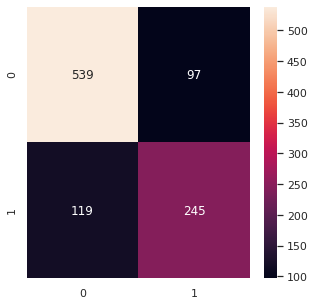

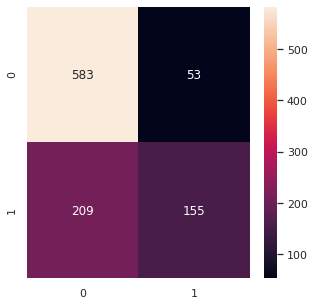

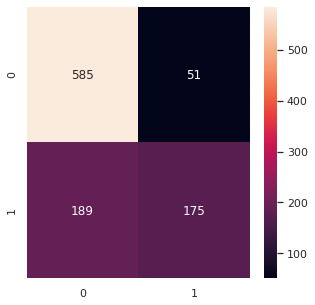

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(Y_test, y_pred, metric_nvpho, name_model_nvpho)
_confusion_matrix(Y_test, y_pred_nv, metric_nvtfidf, name_model_nvtfidf)
_confusion_matrix(Y_test, y_pred_svm, metric_svm, name_model_svm)